In [ ]:
import numpy as np
import pandas as pd
import copy
import re
import string
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from google.colab import drive
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from gensim.models import Word2Vec
from gensim.parsing.porter import PorterStemmer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_recall_curve, precision_score, recall_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.losses import BinaryCrossentropy
from keras.layers import Dense, Dropout, Activation, BatchNormalization, LeakyReLU, Conv1D, MaxPooling1D, Flatten, LSTM, GRU
from keras.callbacks import EarlyStopping, Callback, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import RMSprop, Adam, AdamW
from keras.regularizers import l2
import math
from tqdm import tqdm
from imblearn.over_sampling import SMOTE


drive.mount('/content/gdrive')
nltk.download('stopwords')
nltk.download('punkt')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Importing Dataset

In [ ]:
trainingdata = pd.read_csv('/content/gdrive/MyDrive/mail_data.csv')
trainingdata2 = pd.read_csv('/content/gdrive/MyDrive/spam_ham_dataset.csv')
personalstopwords = pd.read_csv('/content/gdrive/MyDrive/stop-words-english.txt')
trainingdata2.head(10)

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
5,2949,ham,Subject: ehronline web address change\r\nthis ...,0
6,2793,ham,Subject: spring savings certificate - take 30 ...,0
7,4185,spam,Subject: looking for medication ? we ` re the ...,1
8,2641,ham,Subject: noms / actual flow for 2 / 26\r\nwe a...,0
9,1870,ham,"Subject: nominations for oct . 21 - 23 , 2000\...",0


# Data Pre-processing
**Merging Stopwords into 1 Set**

**Creates a function to clean text by:**

1. Change to Lowercase
2. Tokenizing
3. Removing punctuations
4. Removing Stopwords
5. Stemming

In [ ]:
stemming = PorterStemmer()

stopwords_english = set(stopwords.words('english'))

newstopwords = set(personalstopwords.values.ravel())
email_common_words = ["id", "subject", "message"]
newstopwords.update(email_common_words)
combined_stopwords = stopwords_english.union(newstopwords)

def clean(text):
    text = text.lower()
    text = word_tokenize(text)

    #remove stopwords
    temp = []
    for word in text:
        # Remove punctuation before checking for stopwords
        punc_free = ''.join([ch for ch in word if ch not in string.punctuation])
        if punc_free and punc_free not in combined_stopwords and not punc_free.isdigit():
            temp.append(punc_free)

    #stemming the temp list (message content without stopwords)
    stem_text = []
    for item in temp:
        if len(item) >=2:
            stem_text.append(stemming.stem(item))

    return stem_text


example = trainingdata["Message"].iloc[0]
print(clean(example))

['jurong', 'crazi', 'bugi', 'buffet', 'cine', 'amor', 'wat']


**Replacing all the URLs present in the email to "URL"**

In [ ]:
def replace_urls_and_numbers(text):

    # Replace URLs with "URL"
    text = re.sub(r'http\S+|www\S+|https\S+', 'URL', text, flags=re.MULTILINE)
    return text

In [ ]:
trainingdata["replace_url"] = trainingdata["Message"].apply(replace_urls_and_numbers)
trainingdata["token"] = trainingdata["replace_url"].apply(clean)
trainingdata2["replace_url"] = trainingdata2["text"].apply(replace_urls_and_numbers)
trainingdata2["token"] = trainingdata2["replace_url"].apply(clean)

trainingdata2

,Unnamed: 0,label,text,label_num,replace_url,token
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,Subject: enron methanol ; meter # : 988291\r\n...,"[enron, methanol, meter, follow, note, mondai,..."
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,"Subject: hpl nom for january 9 , 2001\r\n( see...","[hpl, nom, januari, attach, file, hplnol, xl, ..."
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,"Subject: neon retreat\r\nho ho ho , we ' re ar...","[neon, retreat, ho, ho, ho, wonder, time, neon..."
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1,"Subject: photoshop , windows , office . cheap ...","[photoshop, window, offic, cheap, main, trend,..."
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0,Subject: re : indian springs\r\nthis deal is t...,"[indian, spring, deal, book, teco, pvr, revenu..."
...,...,...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0,Subject: put the 10 on the ft\r\nthe transport...,"[ft, transport, volum, decreas, contract, ami,..."
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0,Subject: 3 / 4 / 2000 and following noms\r\nhp...,"[nom, hpl, extra, mmcf, weekend, week, nom, st..."
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0,Subject: calpine daily gas nomination\r\n>\r\n...,"[calpin, daili, ga, nomin, juli, mention, earl..."
5169,1409,ham,Subject: industrial worksheets for august 2000...,0,Subject: industrial worksheets for august 2000...,"[industri, worksheet, august, activ, attach, w..."


**Cleaning and merging the 2 datasets**

In [ ]:
trainingdata_copy2 = copy.deepcopy(trainingdata2)
trainingdata_copy2.rename(columns={"label":"Category", "text":"Message"}, inplace=True)
trainingdata_copy2.drop(columns=['Unnamed: 0', 'label_num'],inplace=True)

training = pd.concat([trainingdata, trainingdata_copy2], ignore_index=True)
training

,Category,Message,replace_url,token
0,ham,"Go until jurong point, crazy.. Available only ...","Go until jurong point, crazy.. Available only ...","[jurong, crazi, bugi, buffet, cine, amor, wat]"
1,ham,Ok lar... Joking wif u oni...,Ok lar... Joking wif u oni...,"[lar, joke, wif, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[entri, wkly, comp, win, fa, cup, final, tkt, ..."
3,ham,U dun say so early hor... U c already then say...,U dun say so early hor... U c already then say...,"[dun, hor]"
4,ham,"Nah I don't think he goes to usf, he lives aro...","Nah I don't think he goes to usf, he lives aro...","[nah, nt, usf, live]"
...,...,...,...,...
10738,ham,Subject: put the 10 on the ft\r\nthe transport...,Subject: put the 10 on the ft\r\nthe transport...,"[ft, transport, volum, decreas, contract, ami,..."
10739,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,Subject: 3 / 4 / 2000 and following noms\r\nhp...,"[nom, hpl, extra, mmcf, weekend, week, nom, st..."
10740,ham,Subject: calpine daily gas nomination\r\n>\r\n...,Subject: calpine daily gas nomination\r\n>\r\n...,"[calpin, daili, ga, nomin, juli, mention, earl..."
10741,ham,Subject: industrial worksheets for august 2000...,Subject: industrial worksheets for august 2000...,"[industri, worksheet, august, activ, attach, w..."


# Data Exploration (On merged dataset)

In [ ]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10743 entries, 0 to 10742
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Category     10743 non-null  object
 1   Message      10743 non-null  object
 2   replace_url  10743 non-null  object
 3   token        10743 non-null  object
dtypes: object(4)
memory usage: 335.8+ KB


**Visual representation of commonly used words in a <u>SPAM</u> email - WordCloud**

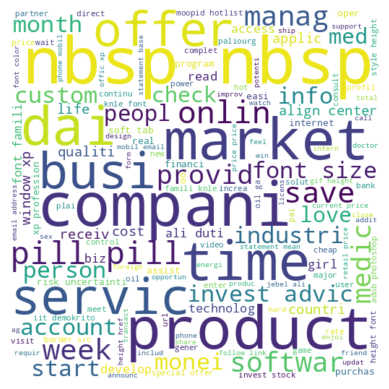

In [ ]:
from wordcloud import WordCloud

wc = WordCloud(width=512, height=512, min_font_size = 10, background_color="white")
spam_text = " ".join(training[training.Category == "spam"]["token"].apply(lambda x: " ".join(x)))
spam_wc = wc.generate(spam_text)
plt.imshow(spam_wc, interpolation="bilinear")
plt.axis("off")
plt.show()



**Visual representation of commonly used words in a <u>NON-SPAM</u> email - WordCloud**

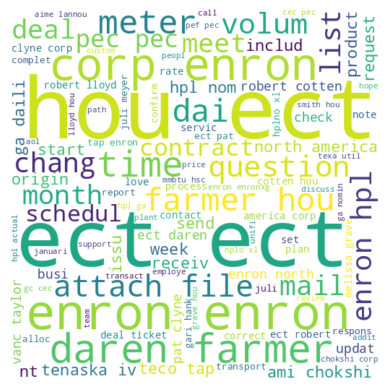

In [ ]:
from wordcloud import WordCloud

wc = WordCloud(width=512, height=512, min_font_size = 10, background_color="white")
spam_text = " ".join(training[training.Category == "ham"]["token"].apply(lambda x: " ".join(x)))
spam_wc = wc.generate(spam_text)
plt.imshow(spam_wc, interpolation="bilinear")
plt.axis("off")
plt.show()

**Distribution of Spam/Ham**

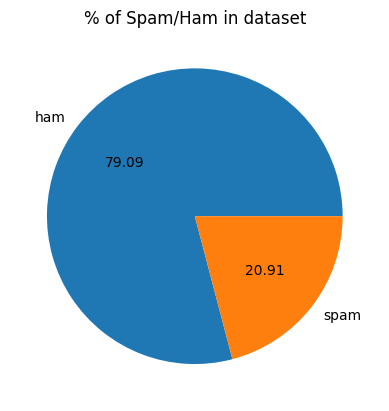

In [ ]:
pie = plt.pie(training['Category'].value_counts(), labels=["ham","spam"], autopct="%0.2f")
plt.title(r"% of Spam/Ham in dataset")
plt.show()

# Continuation of Data Pre-processing
**Encode the Category column to either a 0(Ham)/1(Spam)**

In [ ]:
encoder = LabelEncoder()
training["Category"] = encoder.fit_transform(training["Category"])

training.head(10)

,Category,Message,replace_url,token
0,0,"Go until jurong point, crazy.. Available only ...","Go until jurong point, crazy.. Available only ...","[jurong, crazi, bugi, buffet, cine, amor, wat]"
1,0,Ok lar... Joking wif u oni...,Ok lar... Joking wif u oni...,"[lar, joke, wif, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[entri, wkly, comp, win, fa, cup, final, tkt, ..."
3,0,U dun say so early hor... U c already then say...,U dun say so early hor... U c already then say...,"[dun, hor]"
4,0,"Nah I don't think he goes to usf, he lives aro...","Nah I don't think he goes to usf, he lives aro...","[nah, nt, usf, live]"
5,1,FreeMsg Hey there darling it's been 3 week's n...,FreeMsg Hey there darling it's been 3 week's n...,"[freemsg, hei, darl, week, word, fun, tb, xxx,..."
6,0,Even my brother is not like to speak with me. ...,Even my brother is not like to speak with me. ...,"[brother, speak, treat, aid, patent]"
7,0,As per your request 'Melle Melle (Oru Minnamin...,As per your request 'Melle Melle (Oru Minnamin...,"[request, mell, mell, oru, minnaminungint, nur..."
8,1,WINNER!! As a valued network customer you have...,WINNER!! As a valued network customer you have...,"[winner, valu, network, custom, select, receiv..."
9,1,Had your mobile 11 months or more? U R entitle...,Had your mobile 11 months or more? U R entitle...,"[mobil, month, entitl, updat, colour, mobil, c..."


# Feature Engineering
**Word2Vec**

In [ ]:
# Convert our training data into tokens using nltk's word_tokenize
tokenized_message = [word_tokenize(message) for message in training.Message]

# Train the Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_message, vector_size=50, window=5, min_count=1, workers=4)

In [ ]:
# For each email, we will be finding the corresponding word vector for each word and then average them
def sentence_to_vec(sentence, model):
  words = word_tokenize(sentence)
  vector = np.zeros(model.vector_size)
  count = 0
  for word in words:
      if word in model.wv.key_to_index:  # Check if the word is in the vocabulary
          vector += model.wv[word]
          count += 1
  if count > 0:
      vector /= count
  return vector


feature_set_word2vec = np.array([sentence_to_vec(email, word2vec_model) for email in training.Message])
feature_set_word2vec

array([[-0.11235443,  0.44231487, -1.0257218 , ..., -0.90390147,
         0.4125904 , -0.01018247],
       [-0.6529169 ,  0.82370735, -0.82422721, ..., -0.94137716,
         0.08380274,  0.94402629],
       [-0.11011006,  0.0876523 , -0.66147426, ..., -0.9400768 ,
         0.4936925 , -0.45834068],
       ...,
       [ 0.46567411, -0.24818414, -1.3326003 , ..., -1.15670364,
         1.27575649, -1.14117043],
       [-0.24166323,  0.24930033, -1.32595488, ..., -1.75605578,
         1.16003937, -0.9304308 ],
       [ 0.21732694,  0.21804615, -1.20078984, ..., -2.32176363,
         1.42139756, -0.55119849]])

**Trying TF-IDF & ngrams for the feature set, keeping max feature to 500**

TF-IDF extracts the top 500 most important words while n-grams capture sequences of words to provide context

How does TF-IDF Works:
For example, we have 10 "documents" and the word 'data' appears in 3 of them. If the word 'data' appears 5 times in Document 1, which contains 100 words, the calculations would be:

TF of 'data' in Document 1:

5/100 = 0.05


IDF of 'data' across the corpus:

log(10/3) = 0.52


The final TF-IDF score for 'data' in Document 1 would be:
0.05 x 0.52 = 0.026

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words="english", max_features=500)
X_tfidf = vectorizer.fit_transform(training.token.apply(lambda x: " ".join(x)))
feature_set_tfidf = pd.DataFrame(X_tfidf.toarray())
feature_set_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model Training
**Spliting a training and test set**

Category
0    0.790901
1    0.209099
Name: proportion, dtype: float64


<Axes: xlabel='Category', ylabel='count'>

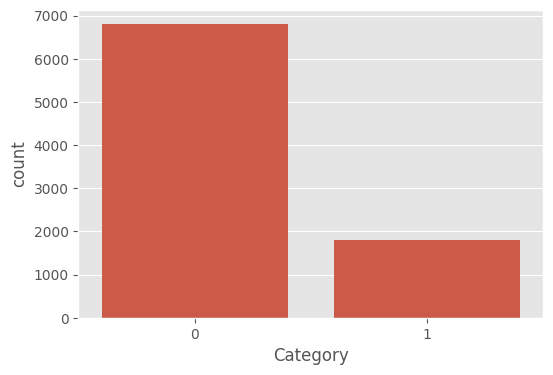

In [ ]:
# Target column
y = training[training.columns[:1]]

# Split for TFidf data and word2vec data
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test = train_test_split(feature_set_tfidf, y, test_size=0.2, random_state=42, stratify=y)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test = train_test_split(feature_set_word2vec, y, test_size=0.2, random_state=42, stratify=y)


print(y_train_word2vec.Category.value_counts(normalize=True))

#plot chart
plt.style.use('ggplot')
plt.figure(figsize=(6,4))
sns.countplot(data=y_train_word2vec, x='Category')

In [ ]:
print(X_train_tfidf.shape)
print(X_train_word2vec.shape)
print(y_train_word2vec.shape)

(8594, 500)
(8594, 50)
(8594, 1)


In [ ]:
# Separate data into training and final test set
# A test size of 20% ensures enough data for testing while retaining sufficient training samples
X_train_full, X_test_final, y_train_full, y_test_final = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

X_train_full = pd.DataFrame(X_train_full.toarray())
X_train_full.reset_index(drop=True, inplace=True)
y_train_full.reset_index(drop=True, inplace=True)

# K-Fold Cross-Validation
# Using 10 splits for k-fold cross-validation to assess model performance
kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracy_scores = []

# Custom callback for tqdm
class TQDMProgressBar(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if epoch == 0:
            self.tqdm_bar = tqdm(total=self.params['epochs'], desc='Training', unit='epoch')
        self.tqdm_bar.update(1)

    def on_epoch_end(self, epoch, logs=None):
        self.tqdm_bar.set_postfix(loss=logs['loss'], accuracy=logs['accuracy'], val_loss=logs['val_loss'], val_accuracy=logs['val_accuracy'])

    def on_train_end(self, logs=None):
        self.tqdm_bar.close()

# Define a learning rate scheduler with exponential decay
def lr_scheduler(epoch, lr):
    decay_rate = 0.95
    decay_step = 10
    return lr * decay_rate if epoch % decay_step == 0 and epoch != 0 else lr

# Focal Loss Function
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        bce = BinaryCrossentropy()(y_true, y_pred)
        pt = tf.exp(-bce)
        loss = alpha * (1 - pt) ** gamma * bce
        return loss
    return focal_loss_fixed

for train_index, val_index in kf.split(X_train_full):
    # Use iloc for safe indexing
    X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
    y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]

# Build a hybrid model of RNN and CNN
# Define the focal loss function
model1 = Sequential()

# Convolutional layers for feature extraction from text sequences
model1.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_full.shape[1], 1)))
model1.add(BatchNormalization())
model1.add(MaxPooling1D(pool_size=2))
model1.add(Dropout(0.3))

# Another convolutional layer
model1.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling1D(pool_size=2))
model1.add(Dropout(0.3))

# Add recurrent layers (LSTM/GRU) for capturing temporal dependencies
model1.add(LSTM(64, return_sequences=True))
model1.add(BatchNormalization())
model1.add(Dropout(0.4))

model1.add(LSTM(32))  #can use GRU here as well
model1.add(BatchNormalization())
model1.add(Dropout(0.4))

# Flatten the output for the dense layers
model1.add(Flatten())

# Fully connected layers for final classification
model1.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))
model1.add(BatchNormalization())
model1.add(Dropout(0.4))

model1.add(Dense(32, activation='relu', kernel_regularizer=l2(0.0001)))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))

model1.add(Dense(1, activation='sigmoid'))

model1.summary()

# Compile the model with gradient clip to stabilize training
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model1.compile(optimizer=optimizer, loss=focal_loss(gamma=2., alpha=0.25), metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)

# Learning rate scheduler for exponential decay
lr_scheduler_callback = LearningRateScheduler(lr_scheduler, verbose=1)

# Train the feedforward model with progress bar, early stopping and callbacks
tqdm_callback = TQDMProgressBar()
history = model1.fit(X_train_full, y_train_full, epochs=100, batch_size=16, validation_data=(X_val, y_val),
                      verbose=1, callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the validation set and store accuracy
loss, accuracy = model1.evaluate(X_val, y_val, verbose=0)
accuracy_scores.append(accuracy)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 498, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 498, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 249, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 249, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 247, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 247, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 123, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 123, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 123, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 123, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 123, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,0

 Total params: 92,545 (361.50 KB)

 Trainable params: 91,777 (358.50 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/100
538/538 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5947 - loss: 0.0711 - val_accuracy: 0.7637 - val_loss: 0.0349 - learning_rate: 0.0010
Epoch 2/100
538/538 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.7431 - loss: 0.0380 - val_accuracy: 0.7637 - val_loss: 0.0320 - learning_rate: 0.0010
Epoch 3/100
538/538 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.7751 - loss: 0.0338 - val_accuracy: 0.7637 - val_loss: 0.0329 - learning_rate: 0.0010
Epoch 4/100
538/538 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.7829 - loss: 0.0302 - val_accuracy: 0.7637 - val_loss: 0.0314 - learning_rate: 0.0010
Epoch 5/100
538/538 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.7915 - loss: 0.0288 - val_accuracy: 0.7637 - val_loss: 0.0288 - learning_rate: 0.0010
Epoch 6/100
538/538 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.7872 - loss: 0.0271 - val_accuracy: 0.7637 - val_loss: 0.0316 - learning_rate: 0.0010
Epoch 7/100
538/538 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.7

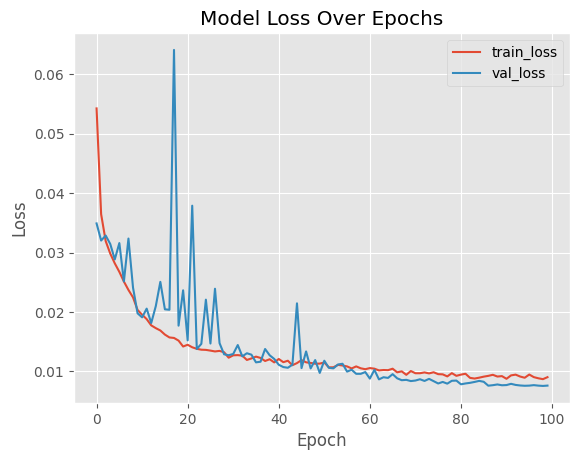

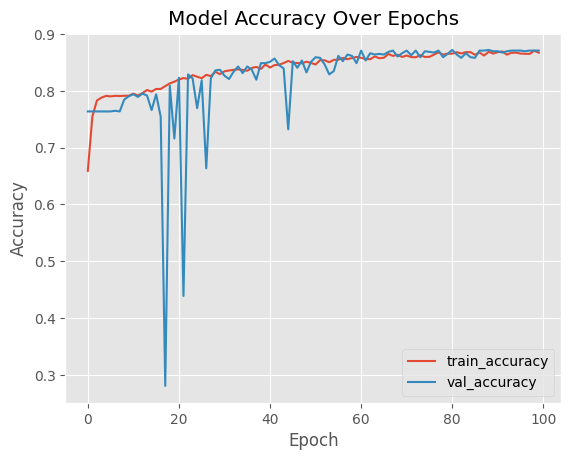

Mean Accuracy over 10 folds: 0.8707799911499023


In [ ]:
# Plot training & validation loss values over epochs
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot accuracy and validation accuracy values over epochs
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

print(f'Mean Accuracy over 10 folds: {np.mean(accuracy_scores)}')

**Model lists**

In [ ]:
# List of models to iterate over
# Naive Bayes is removed in the model list for Word2Vec as the algorithm assumes that all features in
# the input data are non-negative. However, when using word2vec, the features can contain both
# positive and negative values

models_word2vec = {
    "KNN, 5 neighbours" : KNeighborsClassifier(n_neighbors=5),
    "KNN, 3 neighbours" : KNeighborsClassifier(n_neighbors=3),
    "Logistic Regression" : LogisticRegression(random_state=1),
    "XGBoost" : xgb.XGBClassifier(random_state=1),
    'Random Forest Classfier' : RandomForestClassifier(n_jobs=-1,random_state=1)
}

models_tfidf = {
    "KNN, 5 neighbours" : KNeighborsClassifier(n_neighbors=5),
    "KNN, 3 neighbours" : KNeighborsClassifier(n_neighbors=3),
    "Logistic Regression" : LogisticRegression(random_state=1),
    "XGBoost" : xgb.XGBClassifier(random_state=1),
    'Random Forest Classfier' : RandomForestClassifier(n_jobs=-1,random_state=1),
    "Naive Bayes" : MultinomialNB()
}

**Training models using data from word2vec**

In [ ]:
# Fit models and print accuracy scores
for name, model in models_word2vec.items():
    model.fit(X_train_word2vec, y_train_word2vec.values.ravel())
    y_pred = model.predict(X_test_word2vec)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy Score ({name}): {accuracy}")

Accuracy Score (KNN, 5 neighbours): 0.9367147510469986
Accuracy Score (KNN, 3 neighbours): 0.9353187529083294
Accuracy Score (Logistic Regression): 0.9087947882736156
Accuracy Score (XGBoost): 0.9720800372266171
Accuracy Score (Random Forest Classfier): 0.9581200558399255


In [ ]:
# Grid Search for  XGBoost model

xgb_word2vec = xgb.XGBClassifier(random_state=1, n_jobs=-1)

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],         # Default: 100
    'max_depth': [5, 6, 7, 8, 9, 10],                  # Default: 6
    'learning_rate': [0.3, 0.2, 0.1, 0.05],            # Default: 0.3
}

gs = GridSearchCV(estimator=xgb_word2vec, param_grid=param_grid, scoring='accuracy', cv=5, verbose=3)
gs.fit(X_train_word2vec, y_train_word2vec.values.ravel())

print(gs.best_score_)
print(gs.best_params_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END learning_rate=0.3, max_depth=5, n_estimators=100;, score=0.953 total time=   2.6s
[CV 2/5] END learning_rate=0.3, max_depth=5, n_estimators=100;, score=0.955 total time=   0.9s
[CV 3/5] END learning_rate=0.3, max_depth=5, n_estimators=100;, score=0.957 total time=   0.8s
[CV 4/5] END learning_rate=0.3, max_depth=5, n_estimators=100;, score=0.958 total time=   0.9s
[CV 5/5] END learning_rate=0.3, max_depth=5, n_estimators=100;, score=0.962 total time=   4.8s
[CV 1/5] END learning_rate=0.3, max_depth=5, n_estimators=200;, score=0.956 total time=   1.4s
[CV 2/5] END learning_rate=0.3, max_depth=5, n_estimators=200;, score=0.955 total time=   5.2s
[CV 3/5] END learning_rate=0.3, max_depth=5, n_estimators=200;, score=0.957 total time=   1.5s
[CV 4/5] END learning_rate=0.3, max_depth=5, n_estimators=200;, score=0.959 total time=   1.4s
[CV 5/5] END learning_rate=0.3, max_depth=5, n_estimators=200;, score=0.962 total 

In [ ]:
xgb_word2vec_gs = xgb.XGBClassifier(random_state=1,
                  n_jobs=-1,
                  learning_rate=0.1,
                  max_depth=5,
                  n_estimators=500)

xgb_word2vec_gs.fit(X_train_word2vec, y_train_word2vec.values.ravel())

y_pred = xgb_word2vec_gs.predict(X_test_word2vec)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy Score after Gridsearch: {accuracy}")

Accuracy Score after Gridsearch: 0.9706840390879479


In [ ]:
# Update old model
models_word2vec["XGBoost"] = xgb.XGBClassifier(random_state=1,
                  n_jobs=-1,
                  learning_rate=0.1,
                  max_depth=5,
                  n_estimators=500)

In [ ]:
# Consolidated scores for models

for name, model in models_word2vec.items():
    model.fit(X_train_word2vec, y_train_word2vec.values.ravel())
    y_pred = model.predict(X_test_word2vec)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy Score ({name}): {accuracy}")

Accuracy Score (KNN, 5 neighbours): 0.9367147510469986
Accuracy Score (KNN, 3 neighbours): 0.9353187529083294
Accuracy Score (Logistic Regression): 0.9087947882736156
Accuracy Score (XGBoost): 0.9730107026523964
Accuracy Score (Random Forest Classfier): 0.9581200558399255


**Training models using data from TF-IDF**

In [ ]:
# Fit models and print accuracy scores
for name, model in models_tfidf.items():
    model.fit(X_train_tfidf, y_train_tfidf.values.ravel())
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy Score ({name}): {accuracy}")

Accuracy Score (KNN, 5 neighbours): 0.8859934853420195
Accuracy Score (KNN, 3 neighbours): 0.8906468124709167
Accuracy Score (Logistic Regression): 0.9176361098185203
Accuracy Score (XGBoost): 0.9329920893438809
Accuracy Score (Random Forest Classfier): 0.9292694276407631
Accuracy Score (Naive Bayes): 0.9115867845509539


In [ ]:
 # Grid Search for XGBoost model

xgb_tfidf = xgb.XGBClassifier(random_state=1, n_jobs=-1)

param_grid = {"learning_rate" : [0.05, 0.1, 0.2, 0.3],      # Default: 0.3
        "max_depth": [10, 20, 50],                          # Default: 6
        "n_estimators": [50, 100, 200]}                  # Default: 100

gs = GridSearchCV(estimator=xgb_tfidf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=3)

gs = gs.fit(X_train_tfidf, y_train_tfidf.values.ravel())
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score ({name}): {accuracy}")

print(gs.best_score_)
print(gs.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END learning_rate=0.05, max_depth=10, n_estimators=50;, score=0.889 total time=   3.7s
[CV 2/5] END learning_rate=0.05, max_depth=10, n_estimators=50;, score=0.902 total time=   2.9s
[CV 3/5] END learning_rate=0.05, max_depth=10, n_estimators=50;, score=0.888 total time=   2.9s
[CV 4/5] END learning_rate=0.05, max_depth=10, n_estimators=50;, score=0.894 total time=   5.4s
[CV 5/5] END learning_rate=0.05, max_depth=10, n_estimators=50;, score=0.892 total time=   3.8s
[CV 1/5] END learning_rate=0.05, max_depth=10, n_estimators=100;, score=0.899 total time=   4.7s
[CV 2/5] END learning_rate=0.05, max_depth=10, n_estimators=100;, score=0.920 total time=   8.3s
[CV 3/5] END learning_rate=0.05, max_depth=10, n_estimators=100;, score=0.902 total time=   4.7s
[CV 4/5] END learning_rate=0.05, max_depth=10, n_estimators=100;, score=0.901 total time=   4.8s
[CV 5/5] END learning_rate=0.05, max_depth=10, n_estimators=100;, scor

In [ ]:
xgb_tfidf_gs = xgb.XGBClassifier(random_state=1,
                  n_jobs=-1,
                  learning_rate=0.1,
                  max_depth=20,
                  n_estimators=200)

xgb_tfidf_gs.fit(X_train_tfidf, y_train_tfidf.values.ravel())

y_pred = xgb_tfidf_gs.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy Score after Gridsearch: {accuracy}")

Accuracy Score after Gridsearch: 0.93438808748255


In [ ]:
# Update old model
models_tfidf["XGBoost"] = xgb.XGBClassifier(random_state=1,
                       n_jobs=-1,
                       learning_rate=0.1,
                       max_depth=20,
                       n_estimators=200)

In [ ]:
# Consolidated scores for models

for name, model in models_tfidf.items():
    model.fit(X_train_tfidf, y_train_tfidf.values.ravel())
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy Score ({name}): {accuracy}")

Accuracy Score (KNN, 5 neighbours): 0.8855281526291299
Accuracy Score (KNN, 3 neighbours): 0.890181479758027
Accuracy Score (Logistic Regression): 0.9171707771056306
Accuracy Score (XGBoost): 0.93438808748255
Accuracy Score (Random Forest Classfier): 0.9274080967892043
Accuracy Score (Naive Bayes): 0.9106561191251745


# Model Evaluation
**Cross Validating the Models**

Testing only one time might not give us the most reliable result. The testing data are usually randomly sampled from the main set of data, so we might not be get most representative result.  To improve the reliability of our testing, we have to train the test mulitple times, each time using a different set of testing data.

How does Cross Validating works?

1. Train a model
2. Testing the model 10 times
3. Print out the accuracies scores for the 10 tests.
4. Print the average accuracies of the 10 tests.


In [ ]:
def cross_validate_metrics(models, train_data, y_train, cv=10):

  model_performance = {}

  for model_name, model in models.items():

    # Fit the model on training data
    model.fit(train_data, np.ravel(y_train))

    # Didn't average the F1 score so that can store the score for each cross-validation into a dictionary for a box plot later
    avg_f1_score = np.mean(cross_val_score(model, train_data, np.ravel(y_train), cv=cv, scoring='f1'))
    avg_accuracy = np.mean(cross_val_score(model, train_data, np.ravel(y_train), cv=cv, scoring='accuracy'))
    avg_precision = np.mean(cross_val_score(model, train_data, np.ravel(y_train), cv=cv, scoring='precision'))
    avg_recall = np.mean(cross_val_score(model, train_data, np.ravel(y_train), cv=cv, scoring='recall'))

    # Store the average metrics in a nested dictionary to reuse later in visualization
    model_performance[model_name] = {
        'Average Accuracy': avg_accuracy,
        'Average F1': avg_f1_score,
        'Average Precision': avg_precision,
        'Average Recall': avg_recall,
    }

  # Display metrics for each model in a mannered format
  for model_name, metrics in model_performance.items():
    print(f"Model: {model_name}")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    print("="*60)

  return model_performance

**Model Performance for Word2Vec data**

In [ ]:
model_performance_word2vec = cross_validate_metrics(models_word2vec, X_train_word2vec, y_train_word2vec, cv=10)

Model: KNN, 5 neighbours
Average Accuracy: 0.9230841703440994
Average F1: 0.8329145307712315
Average Precision: 0.7647812462937837
Average Recall: 0.9154189944134077
Model: KNN, 3 neighbours
Average Accuracy: 0.9263444513631318
Average F1: 0.8386726929515023
Average Precision: 0.7742961523849105
Average Recall: 0.9154065797641217
Model: Logistic Regression
Average Accuracy: 0.898416492947451
Average F1: 0.749980724853739
Average Precision: 0.773612084548435
Average Recall: 0.7295313469894474
Model: XGBoost
Average Accuracy: 0.9585764951133011
Average F1: 0.8993258283428865
Average Precision: 0.913698731857769
Average Recall: 0.8859155803848541
Model: Random Forest Classfier
Average Accuracy: 0.9470568806345939
Average F1: 0.8638697586881487
Average Precision: 0.9332411728590329
Average Recall: 0.8052172563625077


**Model Performance for TF-IDF data**

In [ ]:
model_performance_tfidf = cross_validate_metrics(models_tfidf, X_train_tfidf, y_train_tfidf, cv=10)

Model: KNN, 5 neighbours
Average Accuracy: 0.8868979613937243
Average F1: 0.6739157481615029
Average Precision: 0.8477327057282151
Average Recall: 0.5598479205462447
Model: KNN, 3 neighbours
Average Accuracy: 0.891785878658256
Average F1: 0.7045730324374629
Average Precision: 0.820142790546249
Average Recall: 0.6182867783985102
Model: Logistic Regression
Average Accuracy: 0.9130780788910849
Average F1: 0.7626187572299873
Average Precision: 0.8878996762487033
Average Recall: 0.6689230291744259
Model: XGBoost
Average Accuracy: 0.9298330941874001
Average F1: 0.8178978913963867
Average Precision: 0.8936327981986709
Average Recall: 0.7545965238981999
Model: Random Forest Classfier
Average Accuracy: 0.9237831984189295
Average F1: 0.8053037353345165
Average Precision: 0.863995310413397
Average Recall: 0.754608938547486
Model: Naive Bayes
Average Accuracy: 0.9078422719766088
Average F1: 0.766203731533883
Average Precision: 0.8154253387201944
Average Recall: 0.7234295468653011


# Data Visualization for findings
**Visualizing the accuracy of each model using a bar graph**

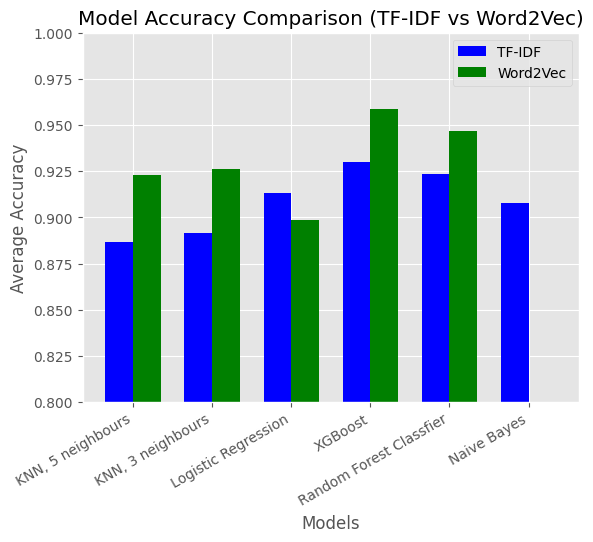

In [ ]:
# Extract accuracies for both TF-IDF and Word2Vec models
tfidf_accuracies = []
word2vec_accuracies = []

for name in model_performance_tfidf:

  tfidf_accuracies.append(model_performance_tfidf[name]["Average Accuracy"])

  if name in model_performance_word2vec.keys():
    word2vec_accuracies.append(model_performance_word2vec[name]["Average Accuracy"])
  else:
    word2vec_accuracies.append(0)

# Define bar width and positions for the bars
bar_width = 0.35
index = np.arange(len(model_performance_tfidf.keys()))

# Create the bar chart
plt.bar(index, tfidf_accuracies, bar_width, label='TF-IDF', color='blue')
plt.bar(index + bar_width, word2vec_accuracies, bar_width, label='Word2Vec', color='green')

# Add labels and titles
plt.xlabel('Models')
plt.ylabel('Average Accuracy')
plt.title('Model Accuracy Comparison (TF-IDF vs Word2Vec)')

# Set x-ticks for the grouped bars
plt.xticks(index + bar_width / 2, model_performance_tfidf.keys(), rotation=30, ha='right')

# Set y-limit for better visibility
plt.ylim(0.8, 1.0)

# Display legend
plt.legend()

# Show the plot
plt.show()


**F1 score of each model across cross-validation folds**

This shows the model's performance across different data splits

What does the Box Plot tell you?
- The width of the box and the length of the whiskers indicate how much the F1 scores vary across the different cross-validation folds.
- If the box and whiskers are narrow, it means the model has consistent performance across different folds.
- If the box or whiskers are wide, it indicates inconsistency in performance across different data splits, suggesting that the model might be sensitive to certain parts of the dataset.


The dots in the graph are outliers representing fold-specific F1 scores that are unusually high or low compared to the others.

1. Word2Vec

In [ ]:
f1_scores_per_model = {}

for model_name, model in models_word2vec.items():
  f1_score_cv = cross_val_score(model, X_train_word2vec, np.ravel(y_train_word2vec), cv=10, scoring='f1')
  f1_scores_per_model[model_name] = f1_score_cv

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future ve

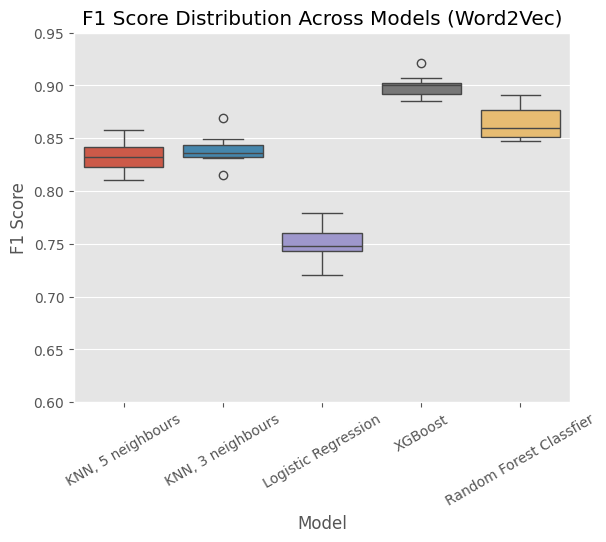

In [ ]:
f1_scores_df = pd.DataFrame(f1_scores_per_model)

# Melt the DataFrame to have a long-form format suitable for Seaborn boxplot
f1_scores_long = f1_scores_df.melt(var_name='Model', value_name='F1 Score')
sns.boxplot(x='Model', y='F1 Score', data=f1_scores_long, hue="Model")

# Add title and labels
plt.title('F1 Score Distribution Across Models (Word2Vec)')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.ylim([0.6, 0.95])
plt.xticks(rotation=30)

# Show the plot
plt.show()

2. TF-IDF

In [ ]:
f1_scores_per_model = {}

for model_name, model in models_tfidf.items():

  f1_score_cv = cross_val_score(model, X_train_tfidf, np.ravel(y_train_tfidf), cv=10, scoring='f1')
  f1_scores_per_model[model_name] = f1_score_cv

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future ve

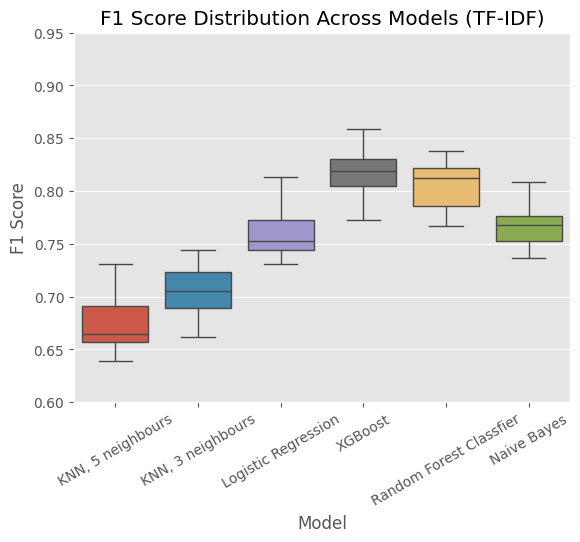

In [ ]:
f1_scores_df = pd.DataFrame(f1_scores_per_model)

# Melt the DataFrame to have a long-form format suitable for Seaborn boxplot
f1_scores_long = f1_scores_df.melt(var_name='Model', value_name='F1 Score')
sns.boxplot(x='Model', y='F1 Score', data=f1_scores_long, hue="Model")

# Add title and labels
plt.title('F1 Score Distribution Across Models (TF-IDF)')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.ylim([0.6, 0.95])
plt.xticks(rotation=30)

# Show the plot
plt.show()

**Precision-Recall Curve**

Precision-Recall curve provides insight into the performance of different models in terms of the trade-off between precision (how many of the predicted positive labels are actually positive) and recall (how many actual positive labels are correctly predicted) for various thresholds

How to interpret the Precision-Recall Curve?
1. A model that stays high on precision while also having good recall, means it's good at finding spam while making few errors.
2. Curves closer to the top-right indicate that the models balance precision and recall well. (higher up is generally better).
3. Curves lower down indicate that these models have lower precision, meaning they make more mistakes by labeling regular emails as spam.

1. Word2Vec

In [ ]:
rc_curve = {}

for model_name, model in models_word2vec.items():

  y_pred = model.predict_proba(X_test_word2vec)[:, 1]
  precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
  rc_curve[model_name] = {
          "Recall": recall,
          "Precision": precision
      }

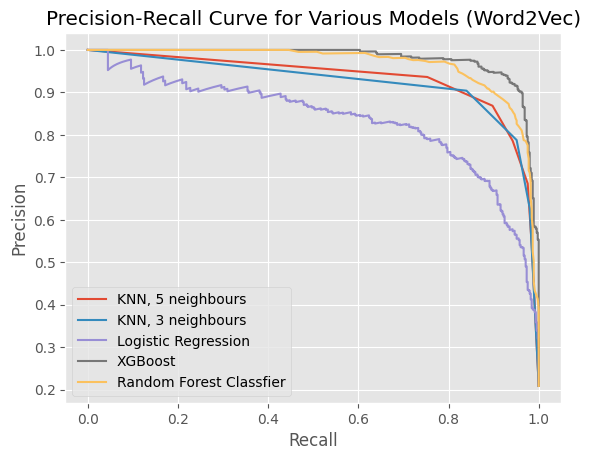

In [ ]:
for i, (model_name, metrics) in enumerate(rc_curve.items()):
    plt.plot(metrics['Recall'], metrics['Precision'], label=model_name)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Various Models (Word2Vec)')
plt.legend(loc='lower left')
plt.show()

2. TF-IDF

In [ ]:
rc_curve = {}

for model_name, model in models_tfidf.items():

  y_pred = model.predict_proba(X_test_tfidf)[:, 1]
  precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
  rc_curve[model_name] = {
          "Recall": recall,
          "Precision": precision
      }

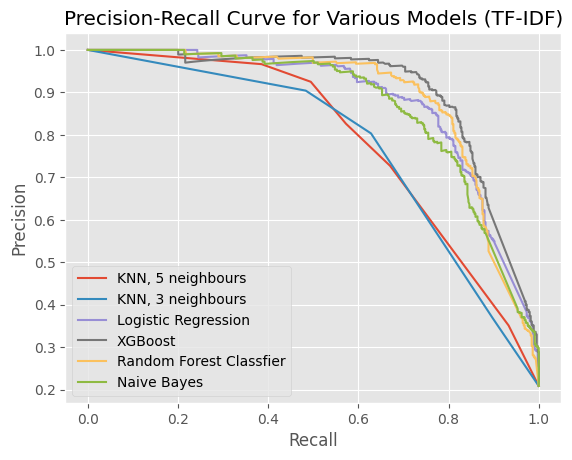

In [ ]:
for i, (model_name, metrics) in enumerate(rc_curve.items()):
    plt.plot(metrics['Recall'], metrics['Precision'], label=model_name)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Various Models (TF-IDF)')
plt.legend(loc='lower left')
plt.show()

**Feature Importance Graph**

A feature importance graph visually shows which features (input variables) in your text content had the most influence on your model's predictions

Why doesn't KNN & Naive Bayes support feature extraction?
- KNN makes predictions by looking at the closest points (neighbors) in the dataset and it doesn't care about which features (like height, weight, or shoe size) are most important. So, it treats all features equally when calculating distance and doesn’t give any special importance to any one feature.
- Naive Bayes assumes all features are equally important and independent of each other. Eg. if someone is tall and loves basketball, Naive Bayes calculates the probability they are a basketball player based on each of these features separately

Model KNN, 5 neighbours does not support feature importance extraction.


Model KNN, 3 neighbours does not support feature importance extraction.


Model: Logistic Regression


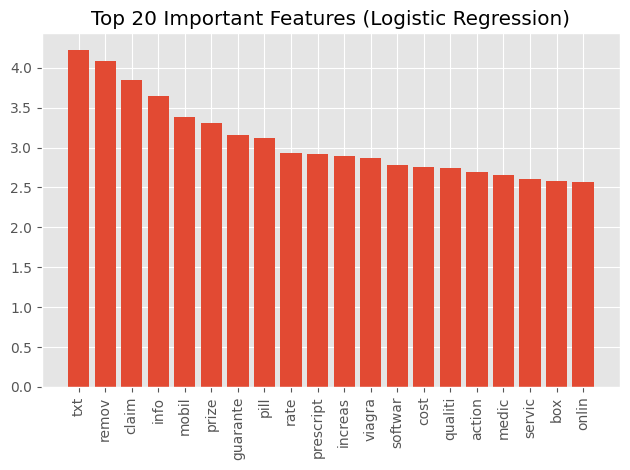



Model: XGBoost


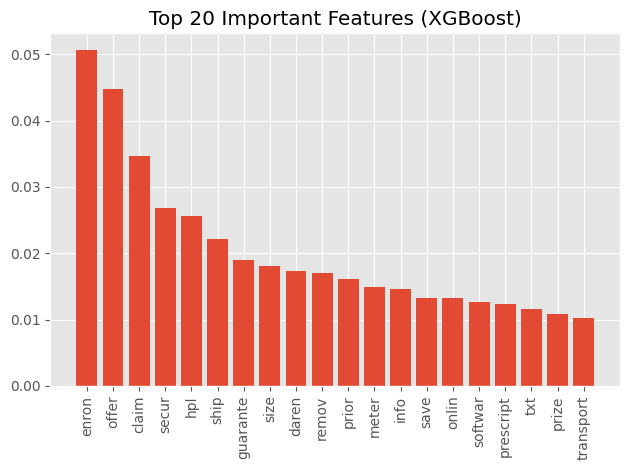



Model: Random Forest Classfier


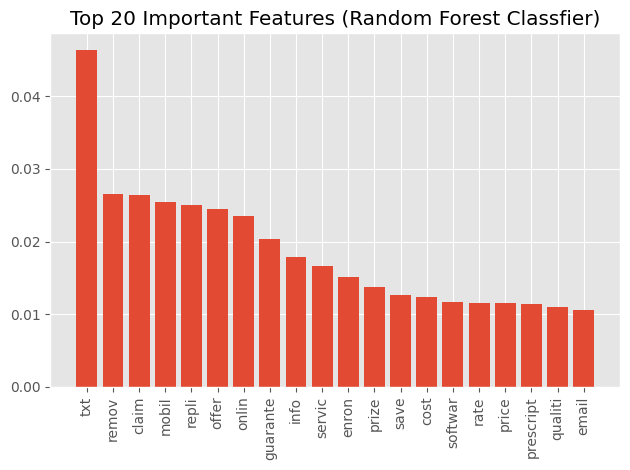



Model Naive Bayes does not support feature importance extraction.




In [ ]:
feature_names = vectorizer.get_feature_names_out()

feature_list = ['Random Forest Classfier', 'XGBoost', "Logistic Regression"]
for model_name, model in models_tfidf.items():
    if model_name in feature_list:
      print(f"Model: {model_name}")

      # Check if the model has feature importance (for tree-based models)
      if hasattr(model, 'feature_importances_'):
          importances = model.feature_importances_
      # Check if the model has coefficients (for linear models like Logistic Regression)
      elif hasattr(model, 'coef_'):
          importances = model.coef_[0]
    else:
        print(f"Model {model_name} does not support feature importance extraction.")
        print("\n" +"="*60 + "\n")
        continue

    # Sort features by importance (descending)
    indices = np.argsort(importances)[::-1]

    # Plot the top 20 important features for each model
    plt.title(f"Top 20 Important Features ({model_name})")
    plt.bar(range(20), importances[indices[:20]], align="center")
    plt.xticks(range(20), [feature_names[i] for i in indices[:20]], rotation=90)
    plt.tight_layout()
    plt.show()
    print("\n" +"="*60 + "\n")